In [2]:
import os, sys

fp_repo = '/Users/rfouyang/workspace/services/ds-fintech'
if fp_repo not in sys.path:
    sys.path.insert(0, fp_repo)

In [3]:
from pathlib import Path
from pprint import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import toad

In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
from util import woe_helper
from util import woe_mono
from util import stable_selection

In [6]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [7]:
fp_base = Path('/Users', 'rfouyang', 'workspace')
#fp_base = Path('C:\\', 'Users', 'USER', 'workspace')
fp_data = Path(fp_base, 'data', 'data.csv')

df_data = pd.read_csv(fp_data, index_col=None)

In [8]:
num_cols = ['Collateral_valuation', 'Age', 'Properties_Total', 'Amount', 'Term', 'Historic_Loans', 'Current_Loans', 'Max_Arrears']
cat_cols = ['Region', 'Area', 'Activity', 'Guarantor', 'Collateral', 'Properties_Status']
features = num_cols + cat_cols
label = 'Defaulter'

In [9]:
for c in cat_cols:
    df_data.loc[:, c] = df_data.loc[:, c].apply(lambda x: str(f"cat_{x}"))

In [10]:
woe = woe_helper.WOE()
woe.fit(df_data, label, exclude=['AppNo', label], method='dt')

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 39.14it/s]


finish combiner fit
finish combiner transform


100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 45.06it/s]


finish WOE fit


In [12]:
df_woe = woe.transform(df_data)

100%|███████████████████████████████████████████| 14/14 [00:00<00:00, 72.46it/s]


# 稳定性筛选

In [57]:
base_estimator = LogisticRegression(penalty='l1', solver='liblinear')

selector = stable_selection.StabilitySelection(base_estimator=base_estimator, lambda_name='C',
                              lambda_grid=np.logspace(-5, -1, 50)).fit(df_woe[features], df_woe[label])

In [56]:
selected_variables = selector.get_support(indices=True)
selected_scores = selector.stability_scores_.max(axis=1)

for idx, (variable, score) in enumerate(zip(selected_variables, selected_scores[selected_variables])):
    print(f'{idx+1:2}. stable score={score}\t{features[idx]}')

 1. stable score=0.85	Collateral_valuation
 2. stable score=1.0	Age
 3. stable score=1.0	Properties_Total
 4. stable score=1.0	Amount
 5. stable score=1.0	Term
 6. stable score=1.0	Historic_Loans
 7. stable score=1.0	Current_Loans
 8. stable score=1.0	Max_Arrears
 9. stable score=1.0	Region
10. stable score=1.0	Area
11. stable score=1.0	Activity
12. stable score=0.99	Guarantor
13. stable score=1.0	Collateral


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Lambda / max(Lambda)', ylabel='Stability score'>)

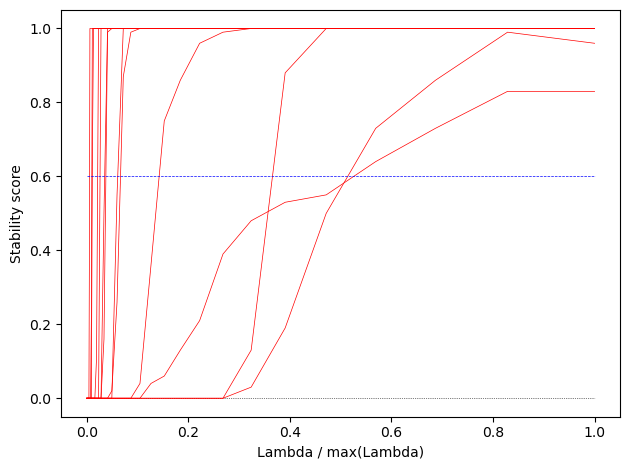

In [51]:
stable_selection.plot_stability_path(selector)

# VIF筛选

In [61]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [65]:
lst_item = list()
for k, c in enumerate(features):
    vif = variance_inflation_factor(df_woe[features], k)
    item = {'feature': c, 'vif': vif}
    lst_item.append(item)

In [70]:
df_vip = pd.DataFrame(lst_item).sort_values(by='vif', ascending=False)
df_vip

,feature,vif
0,Collateral_valuation,2.398628
12,Collateral,1.891132
3,Amount,1.707269
8,Region,1.690797
10,Activity,1.409871
4,Term,1.263871
9,Area,1.229582
13,Properties_Status,1.188399
5,Historic_Loans,1.169254
1,Age,1.159514


# 前后向筛选

In [71]:
from sklearn.feature_selection import RFE